In [29]:
import tensorflow as tf
from prepare_dataset import create_dataset_from_path

## Build CNN Model

In [30]:
def build_layers(input, num):
    # conv layer 1
    x = tf.keras.layers.Conv2D(32, (11, 23), padding='same')(input)
    x = tf.keras.layers.MaxPool2D((4, 4), padding='same')(x)

    # conv layer 2
    x = tf.keras.layers.Conv2D(32, (5, 11), padding='same')(x)
    x = tf.keras.layers.MaxPool2D((4, 4), padding='same')(x)

    # dense layer
    x = tf.keras.layers.Flatten()(x) # flatten
    x = tf.keras.layers.Dense(num, activation='relu')(x)
    output = tf.keras.layers.Dropout(0.5)(x)
    
    return output


def CNN_crop_inputs(image_shape, n_class=26, name='captcha', output_label='labels'):
    # input
    image_input = tf.keras.Input(shape=image_shape, name='input_image')
    
    # split into three sets: 
    # - half image in left side: the first label
    # - entire image: the second, third labels
    # - hale image in right side: the last label
    H, W, C = image_shape
    x1 = tf.keras.layers.Cropping2D(cropping=((0, 0), (0, int(W/2))))(image_input)
    x2 = tf.keras.layers.Cropping2D(cropping=((0, 0), (int(W/2), 0)))(image_input)
    
    # build layers
    x1 = build_layers(x1, 64)
    x = build_layers(image_input, 64)
    x2 = build_layers(x2, 64)

    # combine multi-outputs
    labels = [
        tf.keras.layers.Dense(n_class, name=f'{output_label}_0')(x1),
        tf.keras.layers.Dense(n_class, name=f'{output_label}_1')(x),
        tf.keras.layers.Dense(n_class, name=f'{output_label}_2')(x),
        tf.keras.layers.Dense(n_class, name=f'{output_label}_3')(x2)
    ] 

    # build model
    model = tf.keras.Model(inputs=image_input, outputs=labels, name=name)
    
    return model


In [31]:
image_shape = (60, 120, 1)
n_class = 26

model = CNN_crop_inputs(image_shape, n_class, name='cnn_crop_inputs', output_label='labels')
model.summary()

Model: "cnn_crop_inputs"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 60, 120, 1)] 0                                            
__________________________________________________________________________________________________
cropping2d_16 (Cropping2D)      (None, 60, 60, 1)    0           input_image[0][0]                
__________________________________________________________________________________________________
cropping2d_17 (Cropping2D)      (None, 60, 60, 1)    0           input_image[0][0]                
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 60, 60, 32)   8128        cropping2d_16[0][0]              
____________________________________________________________________________________

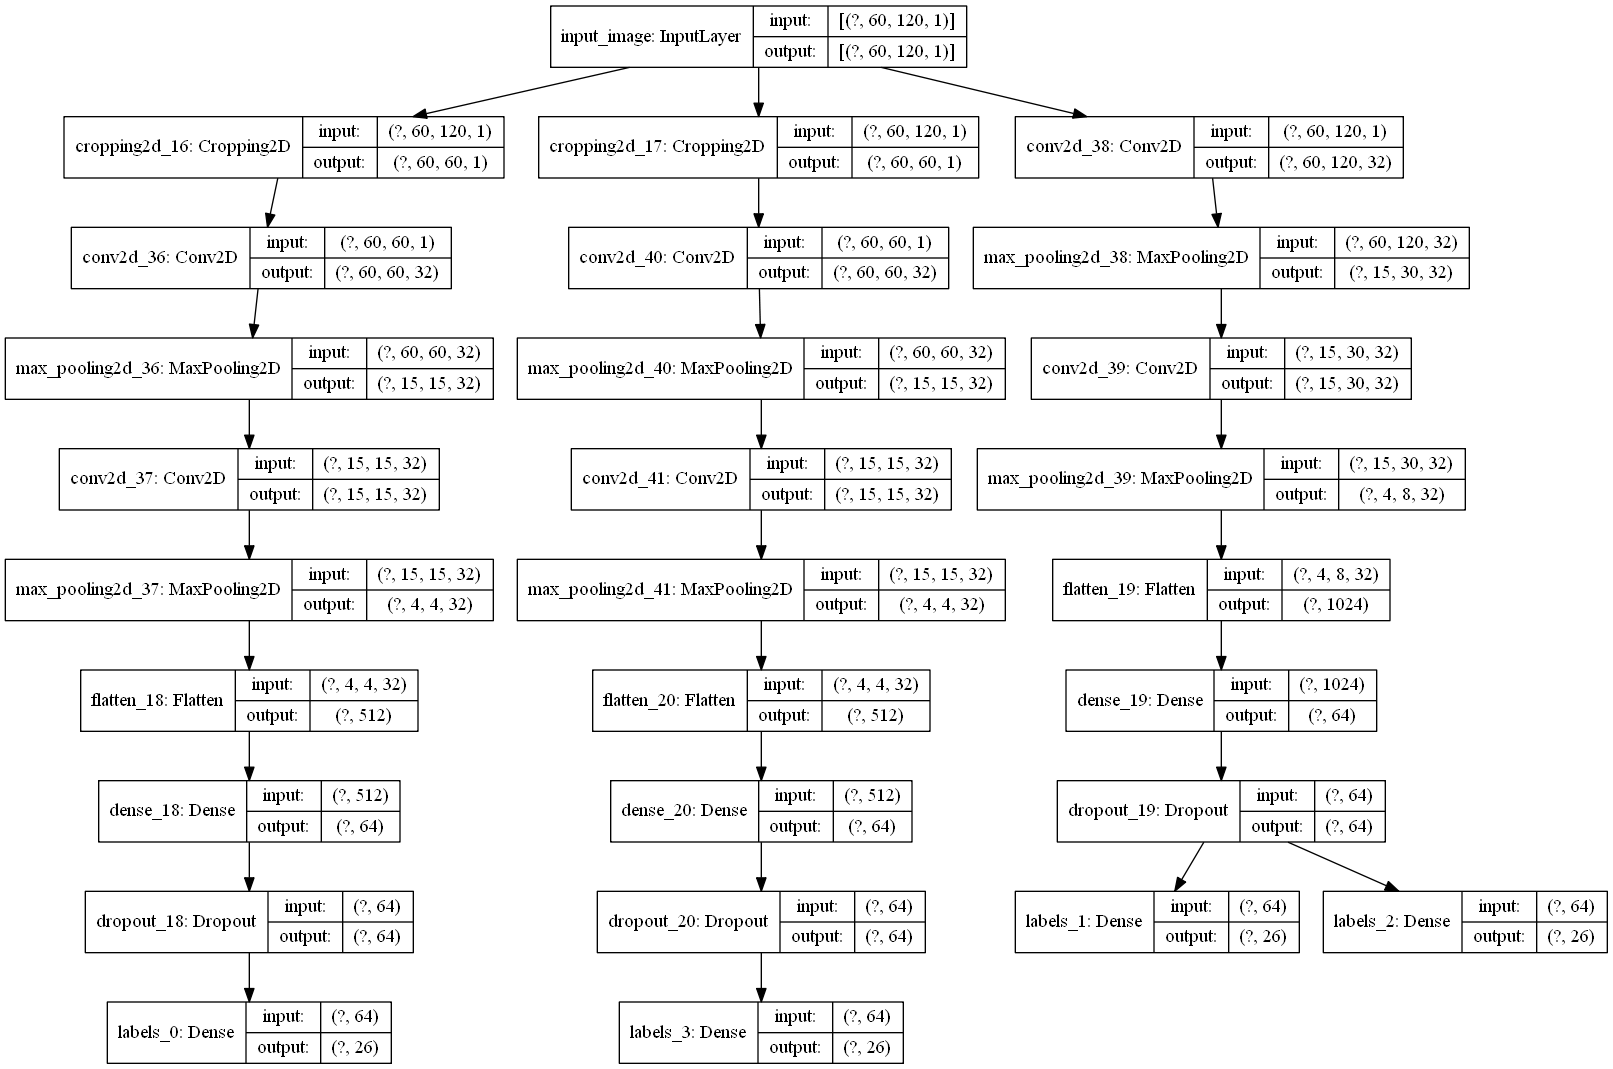

In [32]:
tf.keras.utils.plot_model(model, 'cnn_crop_inputs.png', show_shapes=True)

## Train Model

In [33]:
# load dataset
train_ds = create_dataset_from_path('samples/train/*.jpg', batch_size=128, image_size=(60, 120))
test_ds = create_dataset_from_path('samples/test/*.jpg', batch_size=128, image_size=(60, 120))

In [34]:
# set loss for each output lables, or set a same loss for all labels
# e.g. loss={ f'labels_{i}': 
#   tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) for i in range(n_labels)}
model.compile(optimizer=tf.keras.optimizers.Adadelta(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
import os
model.fit(train_ds, 
          epochs=1, 
          callbacks = [
              tf.keras.callbacks.TensorBoard(log_dir=os.path.join('tensorboard')) # start visualization: tensorboard --logdir mylogdir
          ])